In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import normalvariate

from sklearn.preprocessing import StandardScaler 
from sklearn.neural_network import MLPRegressor

import warnings
warnings.simplefilter('ignore')

In [2]:
def BGM(curve0):
    curve_run = curve0.copy()
    curve = [curve0.copy()]
    for t in range(0, 4):
        y = normalvariate(0,1)
        for i in range(len(curve_run)-1, t, -1):
            A = volY**2*sum( [e/(1+e) for e in curve_run[t+1:i+1]] )
            curve_run[i] *= np.exp((A-volY**2/2)+volY*y)
            i+=1
        curve += [curve_run.copy()]
        t += 1
    
    return curve

In [3]:
def bond(ti, curve):
    df = np.zeros(T)
    b = 0
    for i in range(0, T-ti):
        df[ti+i] = 1/(1+curve[ti+i])
        DF = np.prod(df[ti:ti+1+i])
        b += C[ti+i]*N*DF
        i += 1
        
    b += N*np.prod(df[ti:])
    return b

In [4]:
def MC(n, curve0):
    bonds = []
    rates = []
    for i in range(n):
        new_curve = BGM(curve0)
        rates += [[0]+new_curve[4]]
        bonds += [[bond(0, new_curve[0]),
                   bond(1, new_curve[1]),
                   bond(2, new_curve[2]),
                   bond(3, new_curve[3]),
                   bond(4, new_curve[4])]]
    
    dfs = 1/(1+np.array(rates))
    return np.array(bonds).T, np.array(rates).T, np.array(dfs).T

In [5]:
N = 100 # notional
T = 5 # number of years in total
volY = 0.10 # volatility of the zero curve
K = 101 # strike price

In [6]:
n = 10**6 # number of MC simulations

In [7]:
# contango => evenly distributed among exercise dates
C = [0.03, 0.04, 0.05, 0.06, 0.06] # coupons
y_curve = [0.029, 0.036, 0.041, 0.044, 0.045] # zero curve w/ discrete compounding

In [8]:
curve0 = [y_curve[0]] + [ ( (1+y_curve[i+1])**(i+2) / (1+y_curve[i])**(i+1) )**(1/((i+2)-(i+1))) -1 for i in range(len(y_curve)-1)]
print('The forward curve derived from the zero curve given:', np.around(curve0, 3))

The forward curve derived from the zero curve given: [0.029 0.043 0.051 0.053 0.049]


In [9]:
plt.style.use('seaborn')

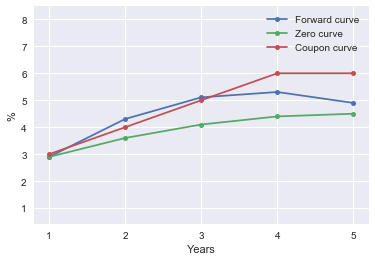

In [10]:
f=plt.figure(figsize = [6, 4])
x1 = range(1,5)
#plt.plot(x, 100*np.array(curve0[1:]), label='Forward curve', marker='o', markersize=5)#, color='g')
#plt.plot(x, 100*np.array(y_curve[1:]), label='Zero curve', marker='o', markersize=5)#, color='r')
#plt.plot(x, 100*np.array(C[1:]), label='Coupon curve', marker='o', markersize=5)#, color='r')
x = range(1,6)
plt.plot(x, 100*np.array(curve0), label='Forward curve', marker='o', markersize=5)#, color='g')
plt.plot(x, 100*np.array(y_curve), label='Zero curve', marker='o', markersize=5)#, color='r')
plt.plot(x, 100*np.array(C), label='Coupon curve', marker='o', markersize=5)#, color='r')
#plt.title('Zero and Forward Curves')
plt.xlabel('Years')
plt.ylabel('%')
plt.xticks(x)
plt.margins(y=0.8)
plt.legend()

In [11]:
mc = MC(n, curve0)
paths, rates, dfs= mc[0], mc[1], mc[2]

In [12]:
# YEAR 4

V = np.zeros(shape=(T,n))
V[4] = np.where(paths[4]>K, paths[4]-K, 0)

In [13]:
# YEAR 3

# making an array of indices of the paths where in year 3 S (ITM) > K
ind_itm_3y = np.where(paths[3]>K)[0]

# selecting S in year 3 where S (ITM) > K
S_3y = paths[3][ind_itm_3y]

# selecting exercise values in year 3
exercise_V_3y = S_3y - K

#discounting to year 3 the cash flows in year 4 where S > K
disc_V_3y = V[4][ind_itm_3y]*dfs[4][ind_itm_3y]

# obtaining values of continuing at year 3
scaler = StandardScaler()  
scaler.fit(S_3y.reshape(-1, 1))  
S_3y_scld = scaler.transform(S_3y.reshape(-1, 1))
mlp = MLPRegressor(hidden_layer_sizes=(3, 10), activation = 'relu', # hidden_layer_sizes = (# hidden layers, # neurons in each layer)
                   solver='adam', max_iter=200, alpha=1e-5) # epochs = # max_iter
mlp.fit(S_3y_scld.reshape(-1, 1), disc_V_3y)
continuation_V_3y = mlp.predict(S_3y_scld.reshape(-1, 1))

# selecting indices of original paths where exercise_V_3y > continuation_V_3y
ind_3y = np.take(ind_itm_3y, np.where(exercise_V_3y > continuation_V_3y))[0]

# inserting exercise values in cash flows in year 3 where exercise_V_3y > continuation_V_3y
V[3][ind_3y] = exercise_V_3y[np.where(exercise_V_3y > continuation_V_3y)]

# inserting zero values in cash flows in year 4 where exercise_V_3y > continuation_V_3y
V[4][ind_3y] = 0

In [14]:
# YEAR 2

# making an array of indices of the paths where in year 2 S (ITM) > K
ind_itm_2y = np.where(paths[2]>K)[0]

# selecting S in year 2 where S (ITM) > K
S_2y = paths[2][ind_itm_2y]

# selecting exercise values in year 2
exercise_V_2y = S_2y - K

# discounting to year 2 the cash flows of year 3 where S > K and the cash flows of year 4 where S > K
disc_V_2y =  np.maximum(V[3][ind_itm_2y]*dfs[3][ind_itm_2y],
                        V[4][ind_itm_2y]*dfs[3][ind_itm_2y]*dfs[4][ind_itm_2y])

# obtaining values of continuing in year 2
scaler = StandardScaler()  
scaler.fit(S_2y.reshape(-1, 1))  
S_2y_scld = scaler.transform(S_2y.reshape(-1, 1))
mlp.fit(S_2y_scld.reshape(-1, 1), disc_V_2y)
continuation_V_2y = mlp.predict(S_2y_scld.reshape(-1, 1))

# selecting indices of original paths where exercise_V_2y > continuation_V_2y
ind_2y = np.take(ind_itm_2y, np.where(exercise_V_2y > continuation_V_2y))[0]

# inserting exercise values in cash flows in year 2 where exercise_V_2y > continuation_V_2y
V[2][ind_2y] = exercise_V_2y[np.where(exercise_V_2y > continuation_V_2y)]

# inserting zero values in cash flows in year 3 and year 4 where exercise_V_2y > continuation_V_2y
V[3][ind_2y], V[4][ind_2y] = 0, 0

In [15]:
# YEAR 1

# making an array of indices of the paths where in year 1 S (ITM) > K
ind_itm_1y = np.where(paths[1] > K)[0]

# selecting S in year 1 where S (ITM) > K
S_1y = paths[1][ind_itm_1y]

# selecting exercise values in year 1
exercise_V_1y = S_1y - K

# discounting to year 1 the cash flows of year 2 where K > S and the cash flows of year 3 where K > S
disc_V_1y =  np.maximum(V[2][ind_itm_1y]*dfs[2][ind_itm_1y],
                        V[3][ind_itm_1y]*dfs[2][ind_itm_1y]*dfs[3][ind_itm_1y],
                        V[4][ind_itm_1y]*dfs[2][ind_itm_1y]*dfs[3][ind_itm_1y]*dfs[4][ind_itm_1y])

# obtaining values of continuing in year 2
scaler = StandardScaler()  
scaler.fit(S_1y.reshape(-1, 1))  
S_1y_scld = scaler.transform(S_1y.reshape(-1, 1))
mlp.fit(S_1y_scld.reshape(-1, 1), disc_V_1y)
continuation_V_1y = mlp.predict(S_1y_scld.reshape(-1, 1))

# selecting indices of original paths where exercise_V_1y > continuation_V_1y
ind_1y = np.take(ind_itm_1y, np.where(exercise_V_1y > continuation_V_1y))[0]

# inserting exercise values in cash flows in year 1 where exercise_V_1y > continuation_V_1y
V[1][ind_1y] = exercise_V_1y[np.where(exercise_V_1y > continuation_V_1y)]

# inserting zero values in cash flows in year 2 and year 3 where exercise_V_1y > continuation_V_1y
V[2][ind_1y], V[3][ind_1y], V[4][ind_1y] = 0, 0, 0

In [16]:
print(f'# of call options: {n:,.0f} \n\n' \
      f't = 4: % ITM call options = {(n-V[4][V[4]==0].shape[0])/n*100:,.2f}% \n' \
      f't = 4: % OTM call options = {V[4][V[4]==0].shape[0]/n*100:,.2f}% \n\n' \
      f't = 3: % ITM call options = {(n-V[3][V[3]==0].shape[0])/n*100:,.2f}% \n' \
      f't = 3: % OTM call options = {V[3][V[3]==0].shape[0]/n*100:,.2f}% \n\n' \
      f't = 2: % ITM call options = {(n-V[2][V[2]==0].shape[0])/n*100:,.2f}% \n' \
      f't = 2: % OTM call options = {V[2][V[2]==0].shape[0]/n*100:,.2f}% \n\n' \
      f't = 1: % ITM call options = {(n-V[1][V[1]==0].shape[0])/n*100:,.2f}% \n' \
      f't = 1: % OTM call options = {V[1][V[1]==0].shape[0]/n*100:,.2f}%')

# of call options: 1,000,000 

t = 4: % ITM call options = 3.38% 
t = 4: % OTM call options = 96.62% 

t = 3: % ITM call options = 25.44% 
t = 3: % OTM call options = 74.56% 

t = 2: % ITM call options = 27.36% 
t = 2: % OTM call options = 72.64% 

t = 1: % ITM call options = 15.16% 
t = 1: % OTM call options = 84.84%


In [17]:
# discounting values to year 0
dfs_cum = np.array([np.cumprod(i) for i in dfs[1:].T]).T
disc_V = V.copy()*dfs_cum

# calculating the price and standard error
c = np.sum([max(i) for i in disc_V.T])/n
c2 = np.sum([max(i)**2 for i in disc_V.T])/n
std_err = np.sqrt((c2-c**2)/n)
call_bond = bond(0,curve0)-c

In [23]:
print(f'The Bermudan call option price is: {c:.10f}. The standard error is: {std_err:.10f}. \n' \
      f'The bond price at t=0: {bond(0,curve0):.10f}. The callable bond price at t=0: {call_bond:.10f}.')

The Bermudan call option price is: 1.1143647465. The standard error is: 0.0010713652. 
The bond price at t=0: 101.1849579254. The callable bond price at t=0: 100.0705931789.


In [19]:
bondprices = np.around([np.mean(paths[0]), np.mean(paths[1]), np.mean(paths[2]), np.mean(paths[3]), np.mean(paths[4])],2)

In [20]:
#print(np.array(y_curve)*100) # zero curve
#print(np.around(np.array(curve0)*100,2)) # forward curve
#print(np.array(C)*100) # coupon curve
print(bondprices[1:]) # bond prices

[101.12 101.47 101.64 101.03]


In [21]:
t4 = (n-V[4][V[4]==0].shape[0])/n*100 # t=4
t3 = (n-V[3][V[3]==0].shape[0])/n*100 # t=3
t2 = (n-V[2][V[2]==0].shape[0])/n*100 # t=2
t1 = (n-V[1][V[1]==0].shape[0])/n*100 # t=1
t_lst = [t1,t2,t3,t4]
print(np.around(t_lst,2))

[15.16 27.36 25.44  3.38]


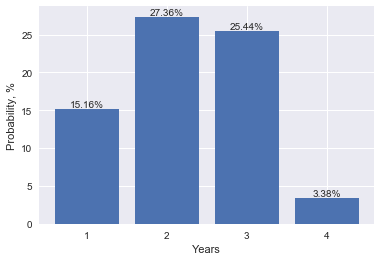

In [22]:
a=plt.figure(figsize = [6, 4])
plt.bar(range(1,5), t_lst)
plt.xticks(range(1,5))
#plt.title('Probability Distribution of Surviving ')
plt.xlabel('Years')
plt.ylabel('Probability, %')

for i in range(len(t_lst)):
    plt.annotate(str(np.round(t_lst[i],2))+'%', xy=(x[i],t_lst[i]), ha='center', va='bottom')